# Calculating Odds on Over/Under Number of Generations By Map

(well, by cup, and by map...)

This notebook analyzes the average number of generations of Golly matches by map, and obtain a mechanism for calculating the expected number of generations for a match to be completed, the probability of waiting less than or more than a certain number of generations for the match to be completed, etc.

In [1]:
import os, sys, subprocess, json, time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
xkcd_colors = sns.xkcd_rgb
GOLLY_GRAY = "#272B30"

## Loading Match Data

Start by loading match data from the `data/` dir:

In [3]:
def fetch_season_data(cup, which_season0):
    cup = cup.lower()
    seas_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{which_season0}', 'season.json')
    if not os.path.exists(seas_file):
        raise Exception(f"Error: season {which_season0} not valid: {seas_file} does not exist")
    with open(seas_file, 'r') as f:
        season0_seas = json.load(f)
    return season0_seas

In [4]:
def fetch_postseason_data(cup, which_season0):
    cup = cup.lower()
    post_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{which_season0}', 'postseason.json')
    if not os.path.exists(post_file):
        raise Exception(f"Error: season {which_season0} not valid: {post_file} does not exist")
    with open(post_file, 'r') as f:
        season0_post = json.load(f)
    return season0_post

## Test drive

We use the methods above to extract point totals and splits for each game, and collate it by map.

In [5]:
season0 = 3
sdat = fetch_season_data('klein', season0)
pdat = fetch_postseason_data('klein', season0)

print(len(sdat))

11


In [6]:
# # Print a sample game
# pprint(sdat[0][0])

# Get info about the map
# print(sdat[0][0]['map'].keys())
print(sdat[0][0]['map']['mapName'])

# Get the length of the match
print(sdat[0][0]['generations'])

East Hellmouth's Revenge
4099


## Method to assemble number of generations by map name

Compile methods to extract and compile length, given either a season and a postseason data structure.

Then iterate over each season number, request the data, and compile the lengths.

In [7]:
def extract_ngenerations(_game, _totals):
    map_name = _game['map']['mapName']
    gens = _game['generations']

    if map_name not in _totals:
        _totals[map_name] = []

    _totals[map_name].append(gens)

In [8]:
def compile_gens_by_map(season_dat, postseason_dat, totals={}):

    # Season first
    for day in season_dat:
        for game in day:
            extract_ngenerations(game, totals)

    # Postseason second
    for series in postseason_dat:
        miniseason = postseason_dat[series]
        for day in miniseason:
            for game in day:
                extract_ngenerations(game, totals)
    
    return totals

### Try it out on a single season

Here is what the above method returns when run on a single season:

In [9]:
season0 = 0
sdat = fetch_season_data('klein', season0)
pdat = fetch_postseason_data('klein', season0)
totals = compile_gens_by_map(sdat, pdat)
pprint(totals)

{'Because Math': [3931, 2612, 1910, 3304, 2498, 3331, 2824, 3052, 4195],
 'Carcinization': [4016, 1808, 1001, 1122, 4625],
 'Charlie Foxtrot': [2466, 1871, 9317, 1936, 3726, 2902, 10168],
 'Crash and Burn': [1053,
                    1693,
                    4211,
                    5864,
                    3093,
                    1288,
                    2929,
                    2081,
                    1202,
                    1062,
                    4101],
 'Donut Hot Tub': [2223, 2166, 1390, 4130, 3223],
 'Double Rainbow': [4943, 3259, 2179, 5683, 1840],
 'East Hellmouth': [2448, 2958, 3041],
 "East Hellmouth's Revenge": [5297, 2177, 3246, 1833, 4046],
 'Engine Room': [2645, 3178, 1782, 1704, 2841],
 'Fistfight at the Opera': [2141, 2324],
 'Justyna': [1943, 2522, 1107, 7513, 2129],
 'Morning Commute': [1965, 1399, 1440, 1059, 3322, 1818, 2569, 1536],
 'Parking Garage': [2361, 1428, 2704],
 'Rabbit Farm': [2069, 1576, 1698, 3906, 3047],
 'Spacetime Complex': [1859, 1805,

### Try it out on multiple seasons

If we don't pass in a totals/diffs counter dictionary, then the method will automatically create an empty dictionary to start with, and manage that for us.

But we can also pass in our own totals/diffs counter dictionary, one that is accumulating totals from across multiple seasons.

In [10]:
totals = {}
diffs = {}
for season0 in range(0, 23):
    sdat = fetch_season_data('klein', season0)
    pdat = fetch_postseason_data('klein', season0)
    compile_gens_by_map(sdat, pdat, totals)
print(totals['West Hellmouth'])

[1987, 2232, 2041, 1547, 1499, 1504, 1476, 1051, 1276, 1067, 1817, 1105, 1713, 1889, 1687, 1785, 2064, 5668, 1968, 6044, 4563, 1351, 2527, 2106, 1939, 2099, 1540, 1161, 1917, 2166, 1240, 1133, 3899, 3603, 3128, 2948, 3005, 1553, 1062, 1961, 3665, 4078, 1038, 3143, 1050, 1645, 1620, 2939, 1288, 1676, 1737, 1006, 2817, 3365, 2736, 1040, 1008, 2811, 2233, 9553, 1367, 1337, 1300, 2659, 2719, 1897, 2584, 2601, 1571, 1962, 1611, 1180, 2323, 1372, 1120, 1937, 1951, 1078, 4192, 2302, 2656, 1349, 2181, 2851, 1952, 1799, 1590, 3895, 1155, 1015, 1554, 3787, 2580, 1220, 2548, 1558, 1072, 1757, 7725, 1356, 3073, 6071, 1255, 1731, 1804, 1922, 1934, 3156, 1389, 7520, 3485, 2728, 2162, 4240, 2290, 1372, 2554, 1528, 1711, 1898, 2282, 3385, 1369, 1552, 2640, 1751, 1372, 1924, 3056, 2504, 2102, 4039, 3296, 1990, 3078, 1302, 1218, 2054, 3356, 2330, 1254, 3745]


## Toroidal Cup

In [16]:
tor_totals = {}
for season0 in range(0, 23):
    sdat = fetch_season_data('toroidal', season0)
    pdat = fetch_postseason_data('toroidal', season0)
    compile_gens_by_map(sdat, pdat, tor_totals)

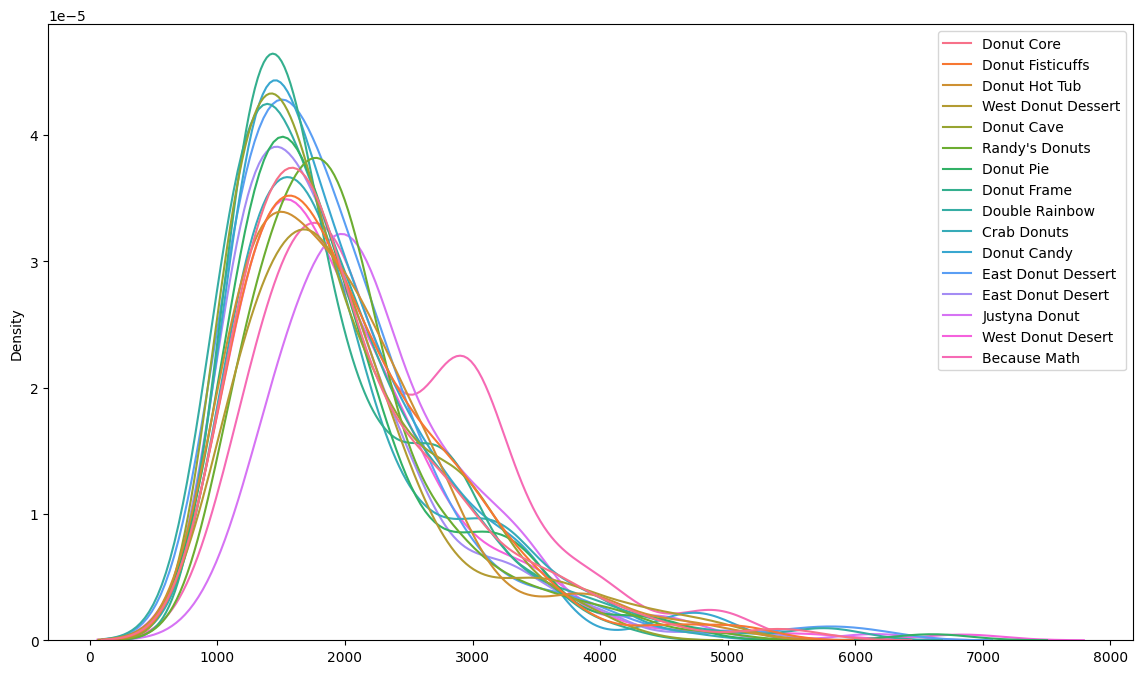

In [17]:
# This histogram plot is cool but has too much information to easily interpret...
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.kdeplot(data=tor_totals, ax=ax)

plt.show()

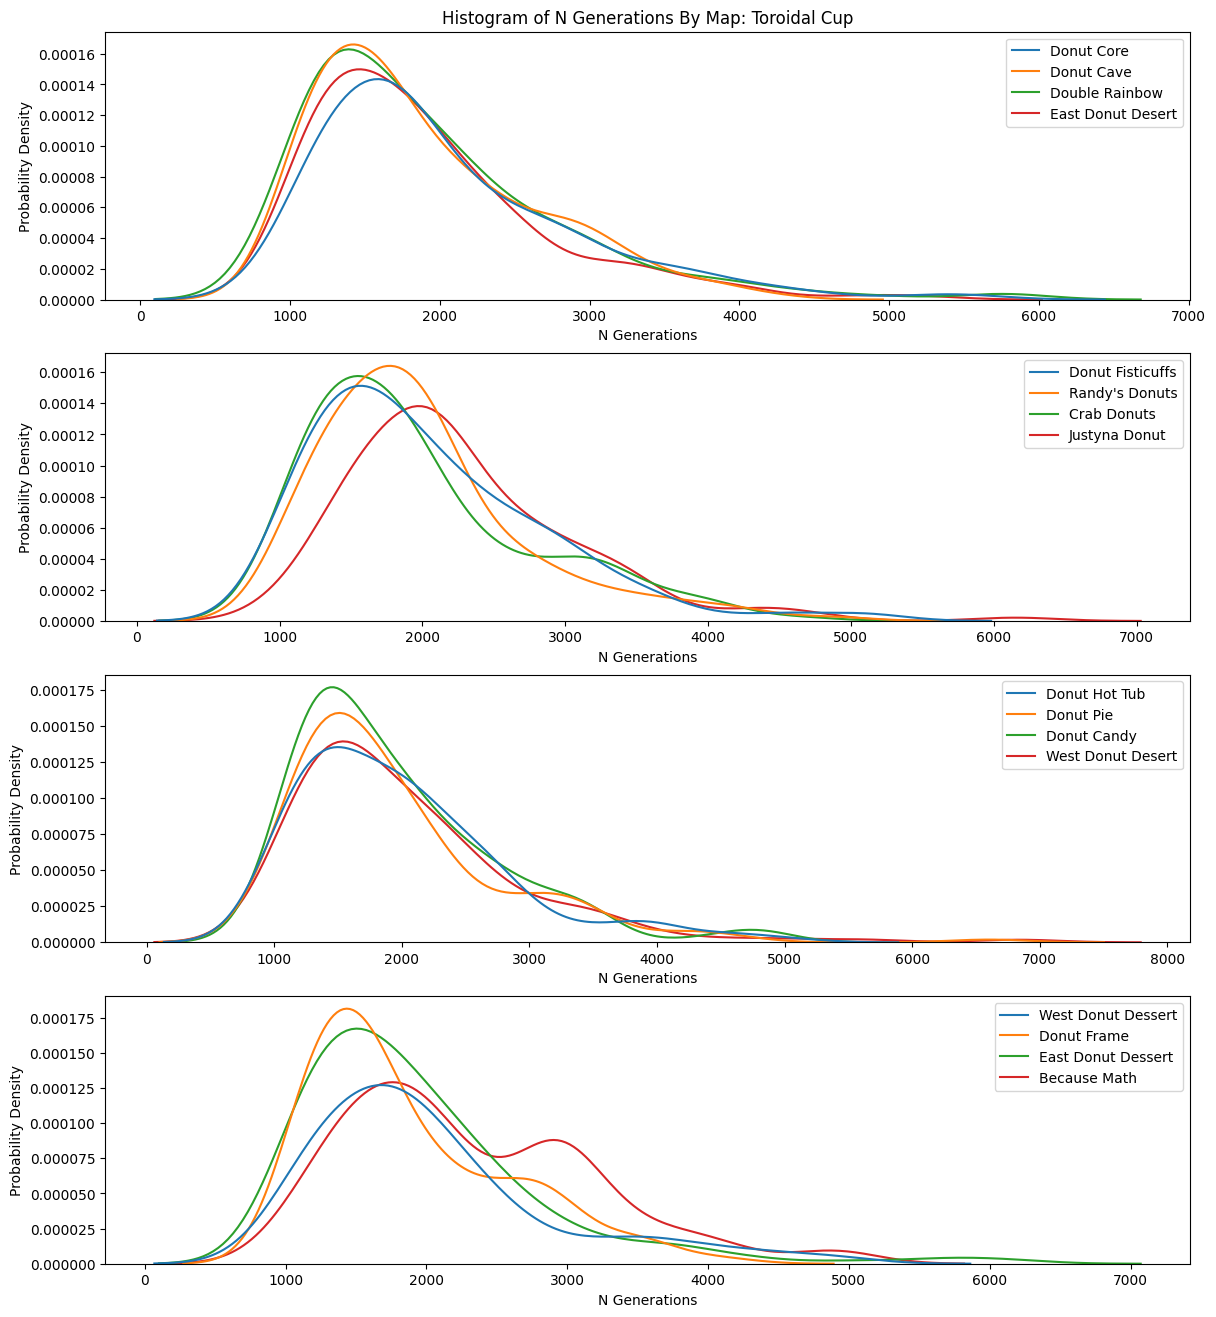

In [18]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# This bit of magic will iterate over all the keys in totals, and split into 4 groups
for m, aax_ in enumerate(axes):
    sns.kdeplot(data={k: v for i, (k, v) in enumerate(tor_totals.items()) if i%4==m}, ax=aax_)
    aax_.set_xlabel("N Generations")
    aax_.set_ylabel("Probability Density")

axes[0].set_title("Histogram of N Generations By Map: Toroidal Cup")
plt.show()

## Star Cup

In [19]:
star_totals = {}
for season0 in range(0, 23):
    sdat = fetch_season_data('star', season0)
    pdat = fetch_postseason_data('star', season0)
    compile_gens_by_map(sdat, pdat, star_totals)

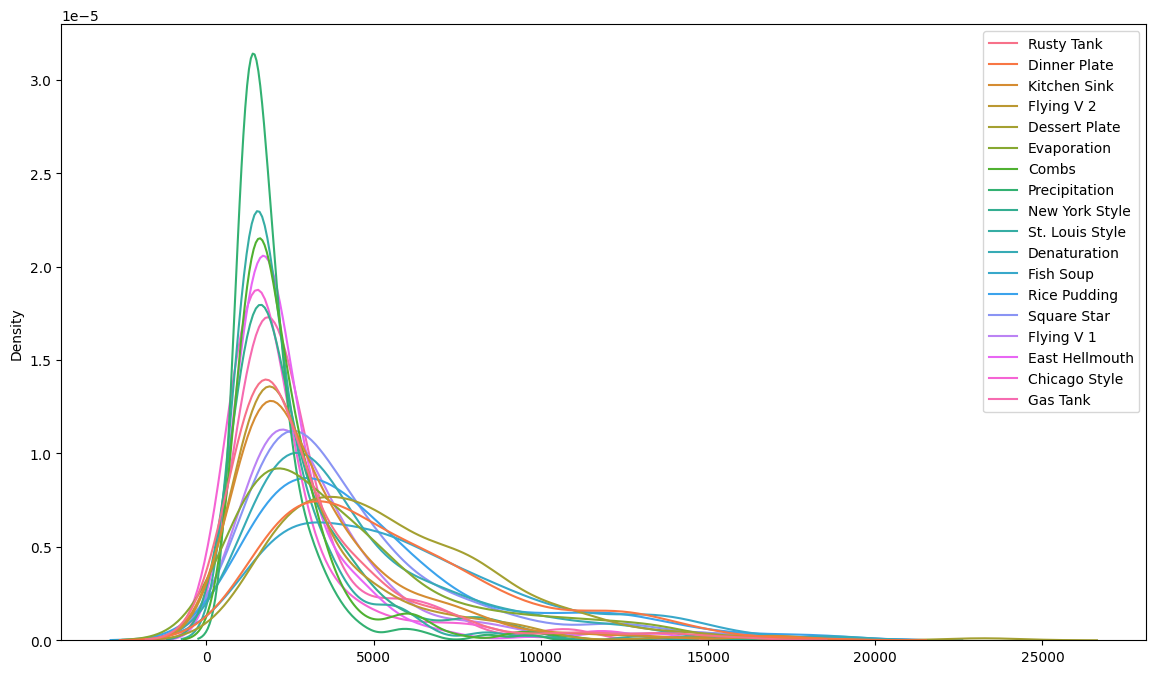

In [20]:
# This histogram plot is cool but has too much information to easily interpret...
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.kdeplot(data=star_totals, ax=ax)

plt.show()

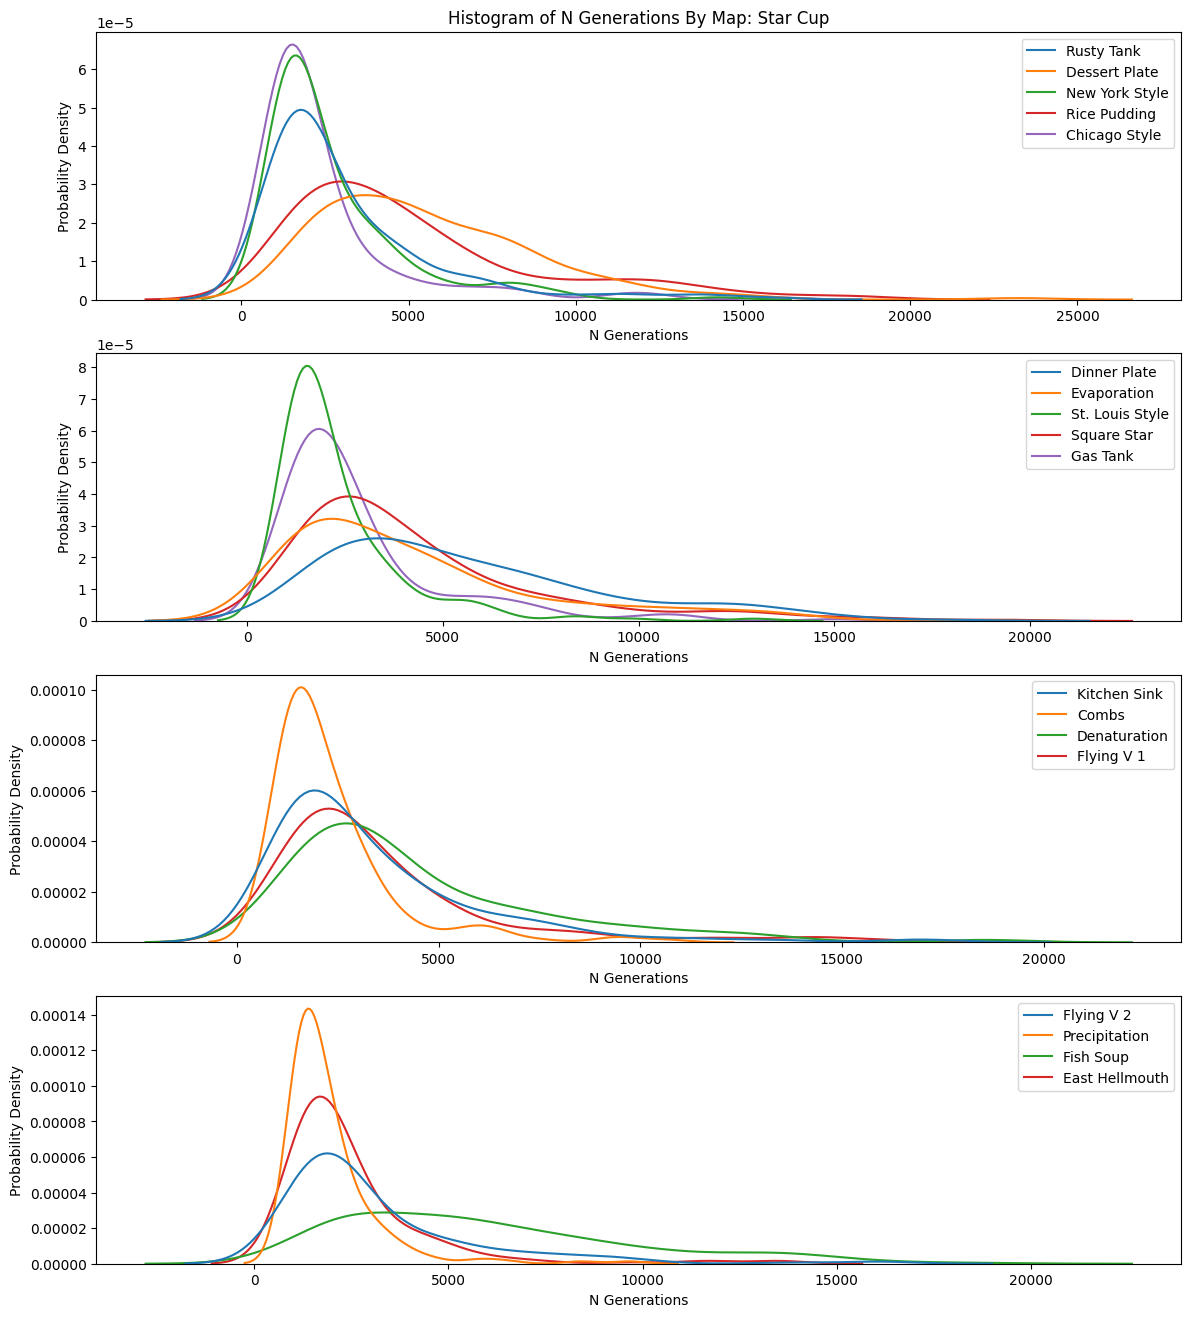

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# This bit of magic will iterate over all the keys in totals, and split into 4 groups
for m, aax_ in enumerate(axes):
    sns.kdeplot(data={k: v for i, (k, v) in enumerate(star_totals.items()) if i%4==m}, ax=aax_)
    aax_.set_xlabel("N Generations")
    aax_.set_ylabel("Probability Density")

axes[0].set_title("Histogram of N Generations By Map: Star Cup")
plt.show()

## Empirical CDF For Determining Split

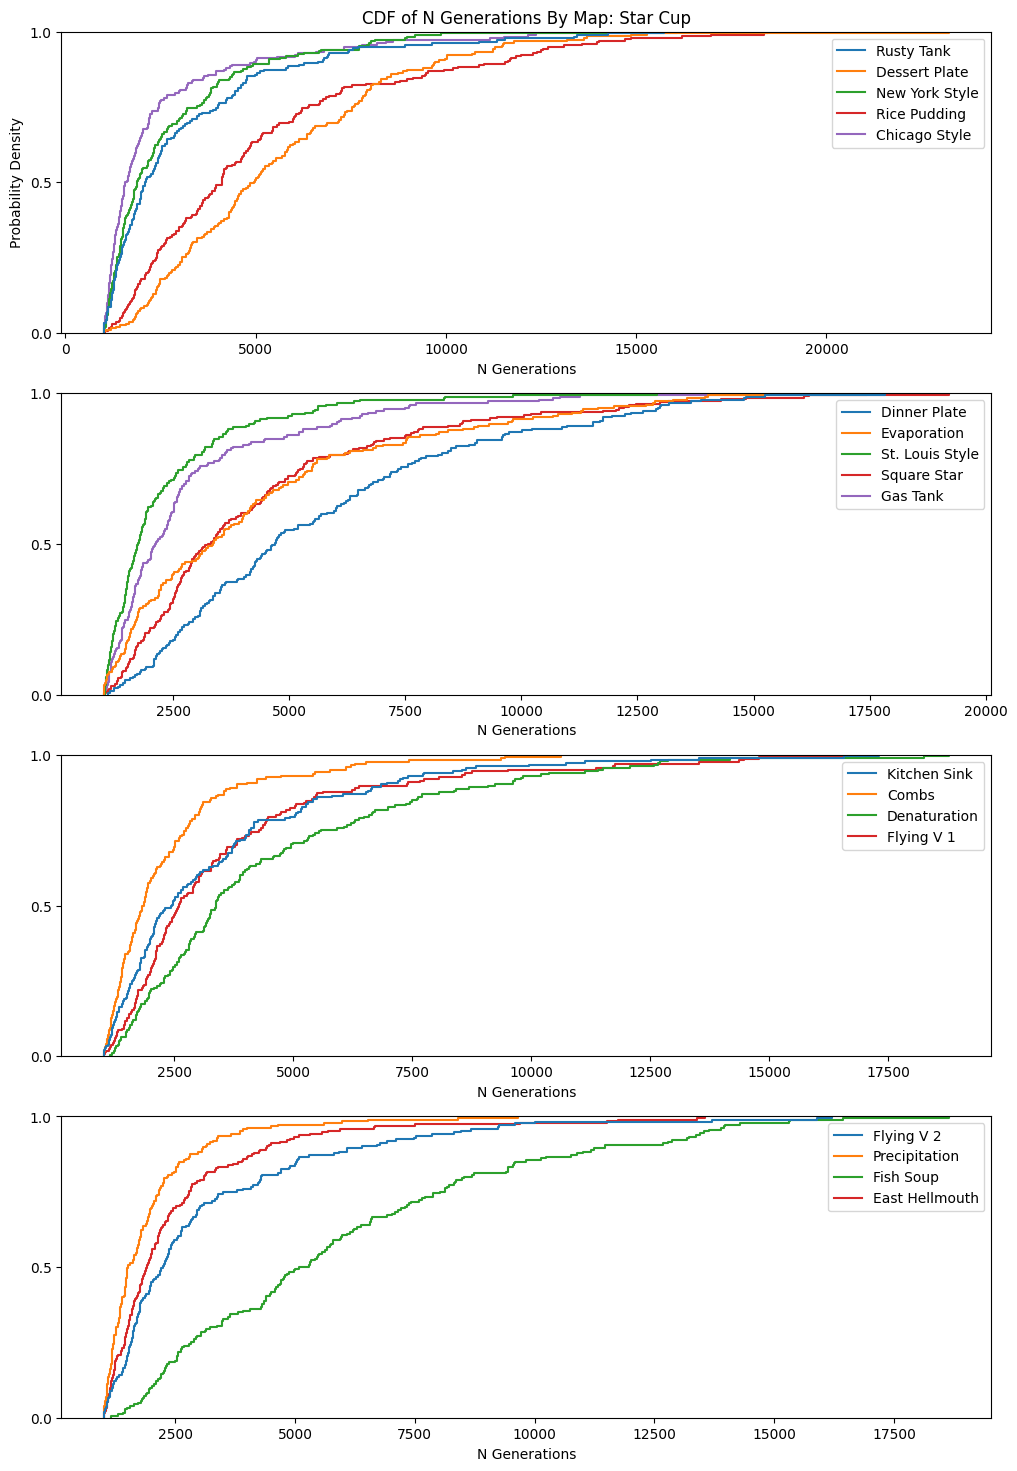

In [22]:
fig, axes = plt.subplots(4, 1, figsize=(12, 18))

# This bit of magic will iterate over all the keys in totals, and split into 4 groups
for m, aax_ in enumerate(axes):
    sns.ecdfplot(data={k: v for i, (k, v) in enumerate(star_totals.items()) if i%4==m}, ax=aax_)
    aax_.set_ylabel("")
    aax_.set_yticks([0.0, 0.5, 1.0])
    aax_.set_xlabel("N Generations")
    # aax_.set_facecolor(GOLLY_GRAY)

axes[0].set_ylabel("Probability Density")
axes[0].set_title("CDF of N Generations By Map: Star Cup")

plt.show()

## Empirical CDF Function, Quantile Function

What we really want is a CDF function, or better yet, an inverse CDF function. We can get an empirical CDF function with the statsmodel package:

In [79]:
import numpy as np
import scipy
from statsmodels.distributions.empirical_distribution import ECDF

n = 100
x = np.linspace(1000,17000,n)
f = lambda x,mu,sigma: scipy.stats.norm(mu,sigma).cdf(x)

ecdf = ECDF(star_totals['Fish Soup'])
data = ecdf(x[:7])

Alternatively, if we are ONLY interested in the value of N Generations where the empirical CDF equals 0.5, we can use Numpy's quantile function:

In [82]:
np.quantile(star_totals['Fish Soup'], q=0.50)

5193.0

Note that this differs from the mean:

In [70]:
np.mean(star_totals['Fish Soup'])

5960.461111111111

It is also worth noting that the exponential distribution function $f(x; \lambda) = \lambda e^{-\lambda x}$  does a poor job of representing the number of generations in a game, since the assumptions underlying the exponential distribution (waiting times) don't really apply in this case. Better to use the empirical CDF, straight from the data.

In [84]:
for map_name in star_totals:
    q = np.quantile(star_totals[map_name], q=0.50)
    print(f"50th quantile for map {map_name} = {q:0.0f}")

50th quantile for map Rusty Tank = 2110
50th quantile for map Dinner Plate = 4683
50th quantile for map Kitchen Sink = 2449
50th quantile for map Flying V 2 = 2244
50th quantile for map Dessert Plate = 4949
50th quantile for map Evaporation = 3368
50th quantile for map Combs = 1836
50th quantile for map Precipitation = 1507
50th quantile for map New York Style = 1892
50th quantile for map St. Louis Style = 1742
50th quantile for map Denaturation = 3370
50th quantile for map Fish Soup = 5193
50th quantile for map Rice Pudding = 4105
50th quantile for map Square Star = 3280
50th quantile for map Flying V 1 = 2596
50th quantile for map East Hellmouth = 1907
50th quantile for map Chicago Style = 1597
50th quantile for map Gas Tank = 2128
